# Step 0: Installing requirements

The [conda](https://docs.conda.io/en/latest/) package manager is used to install the packages used in this workflow. If GROMACS is not already installed on your machine, it can be obtained by running `conda install -c bioconda gromacs`
## Also need ILForcefields but that's private

In [1]:
!conda install --file requirements.txt --yes

Solving environment: done

# All requested packages already installed.



## Step 1: Using the KPL force field

The Köddermann-Paschek-Ludwig Forcefield is a forcefield commonly used to atom type Ionic Liquids. More information can be found at these references:

Modeling Ionic Liquids Using a Systematic All-Atom Force Field
José N. Canongia Lopes, Johnny Deschamps, and Agílio A. H. Pádua
The Journal of Physical Chemistry B 2004 108 (6), 2038-2047
DOI: 10.1021/jp0362133

Köddermann T, Paschek D, Ludwig R. Molecular dynamic simulations of ionic liquids: a reliable description of structure, thermodynamics and dynamics. Chemphyschem. 2007;8(17):2464-2470. doi:10.1002/cphc.200700552

A small portion of KPL has been implemented in files provided in this workflow.

## Step 2: Building the mBuild compound
We are able to load in the molecules through `mol2` files which we can create using software such as Avogadro

In [22]:
import mbuild as mb

tf2n = mb.load('tfsi.mol2')
emim = mb.load('emim.mol2')

emim.name = 'emim'
tf2n.name = 'tf2n'

We are then able to [mb.fill_box](https://mosdef.org/mbuild/recipes.html?highlight=fill_box#mbuild.packing.fill_box) to specify size of box, number of atoms, density and so on.

In [23]:
system = mb.fill_box(compound=[tf2n, emim],
        n_compounds=[50,50], density=1530)

## Step 3: Applying the Foyer force field
The `kpl.xml` provided can be found on [ILforcefields](https://github.com/mattwthompson/ilforcefields)
We can apply the Forcefield to the system we generated in the previous cell.


In [24]:
from foyer import Forcefield

FF = Forcefield('kpl.xml')

tf2nP = mb.Compound()
emimP = mb.Compound()

Due to having to sometimes use different Forcefields for different compounds and Foyer currently not supporting assigning different FF parameters to different compounds we must use a for loop to separate the system out into individual compounds and then apply the forcefields separately. 

But in this case the same Forcefield is being used, so technically we don't have to do the for loop but it's useful to see/have sample code.

In [25]:
for child in system.children:
    if child.name == 'emim':
        emimP.add(mb.clone(child))
    else:
        tf2nP.add(mb.clone(child))

tf2nPM = FF.apply(tf2nP, residues=['tf2n'])  #apply forcefield to IL's
emimPM = FF.apply(emimP, residues=['emim'] )

systemPM = tf2nPM + emimPM

Then we can save the system as `top` and `gro` files which store the initial state of the system

In [26]:
systemPM.save('init.top', overwrite=True)
systemPM.save('init.gro', overwrite=True)

## Step 4: Running the simulation

As with most simulation engines, an input or control file is necessary. 
For gromacs, this is the `mdp` file. There are 4 `mdp` files stored in the `mdp_files` folder, they each do a different job. The fill box function just puts all the molecules in a box without much thought to it's positioning, that's why we first run the Energy Minization (em) step.

In [27]:
import subprocess

grompp_cmd = 'gmx grompp -f mdp_files/em.mdp -c init.gro -p init.top -o em.tpr'
p = subprocess.Popen(grompp_cmd, shell=True, universal_newlines=True,
                    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()
with open('em.out', 'w') as f:
    f.write(out)
with open('em.err', 'w') as f:
    f.write(err)

This creates a `em.tpr` file, which can then be run.

In [28]:
mdrun_cmd = 'gmx mdrun -deffnm em'
p = subprocess.Popen(mdrun_cmd, shell=True, universal_newlines=True,
                    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()
with open('nvt.out', 'w') as f:
    f.write(out)
with open('nvt.err', 'w') as f:
    f.write(err)

Next we run a `nvt` ensemble, this stabilises the Temperature we want to run the Simulation at.

In [29]:
grompp_cmd = 'gmx grompp -f mdp_files/nvt.mdp -c em.gro -p init.top -o nvt.tpr'
p = subprocess.Popen(grompp_cmd, shell=True, universal_newlines=True,
                    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()
with open('nvt.out', 'w') as f:
    f.write(out)
with open('nvt.err', 'w') as f:
    f.write(err)

In [30]:
mdrun_cmd = 'gmx mdrun -deffnm nvt'
p = subprocess.Popen(mdrun_cmd, shell=True, universal_newlines=True,
                    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()
with open('nvt.out', 'w') as f:
    f.write(out)
with open('nvt.err', 'w') as f:
    f.write(err)

Next we have to run an `npt` ensemble, to stabilise the system to a Pressure which we want it to run at and then we can run our Sample simulation, `run`. But we are not going to run a `npt` or `run` as it takes too long, the commands to run them are:

`gmx grompp -f mdp_files/npt.mdp -c nvt.gro -p init.top -o npt.tpr`

`gmx mdrun -deffnm npt`

`gmx grompp -f mdp_files/run.mdp -c npt.gro -p init.top -o run.tpr`

`gmx mdrun -deffnm run`

The `edr` file generated by the `run` Simulation is in this folder and we will be using it to do some elementary analysis of the energies and properties of the system we generated.

## Step 5: Analysis

Without running enough simulations to fully equilibrate and sample a system, we can simply do a check on the energy of the system as a function of time. We use the `panedr` package to parse the EDR file, which is a binary format, to a `pandas` dataframe.

In [26]:
import panedr

df = panedr.edr_to_df('run.edr')

energies = ['Potential', 'LJ (SR)', 'Angle', 'Density']

Gromacs also has it's own inbuilt function which allows us to analyse information from the simulation. Called `gmx energy`. Calling `gmx energy` also gives a list of all the energies and properties we can see/calculate.

Try running `gmx energy -f done/run.edr` in your Terminal.

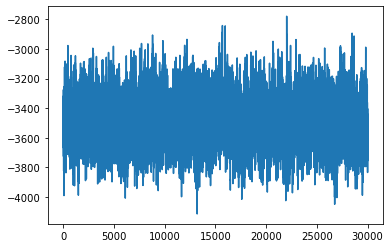

In [38]:
import matplotlib.pyplot as plt

plt.plot( df['Time'], (df['Coulomb (SR)'] + df['Coul. recip.']), label='Coulomb')

1507.421457561929


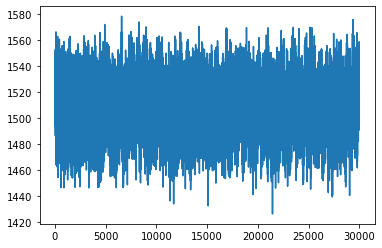

In [39]:
 plt.plot(df['Time'], df['Density'], label=energy)
 print(np.average(df['Density']))

We can use `mdtraj` and [mtools](https://github.com/mattwthompson/mtools) to calculate the Diffusivity of a system by calculating the Mean Squared Displacement (MSD). Please `git clone https://github.com/mattwthompson/mtools` and `pip install -e .` on Terminal to install mtools on your system.

$Note$: We cannot do the following steps without the trajectory `xtc` files generated by `npt` or `run` simulations which are not provided in the folder as they are too large. The resulting `msd` of the system calculated from `run.xtc` is given in `msd.txt`.

In [40]:
import mdtraj as md
from mtools.post_process import calc_msd
from mtools.gromacs.gromacs import unwrap_trj
import numpy as np

Gromacs wraps all it's trajectories and to get a good estimate of Diffusivity we must unwrap the trajectory.

In [41]:
unwrap_trj('run.xtc')

Now we can load in our trajectory using mdtraj.

In [42]:
data = md.load('run_unwrapped.xtc', top = 'run.gro')

Then we can calculate the MSD

In [43]:
total, msd, x, y = calc_msd(data)

np.savetxt('msd.txt',np.vstack([data.time, msd]))

print(total)

4.518273023725416e-11
